# Test of Nested Arrays

P. Pal and P. P. Vaidyanathan, "Nested Arrays: A Novel Approach to Array Processing With Enhanced Degrees of Freedom," in IEEE Transactions on Signal Processing, vol. 58, no. 8, pp. 4167-4181, Aug. 2010



In [1]:
# number of sensors
N = 6          
# sensor positions
N_  = Int(N/2)
pos = [collect(1:N_)...,collect(range(N_+1,step=N_+1,length=N_))...]
@show pos';

pos' = [1 2 3 4 8 12]


In [2]:
using LinearAlgebra: diagm

# data generation
T     = 4_800                       # sample size
SNR   = -10                          # SNR in dB
θθ    = [-60,-45,-30,-15,0,15,30,45,60] # source angles (degrees)
ϕϕ    = π*sind.(θθ)                 # source phases 
ns    = length(ϕϕ)                  # number of sources
Σ     = diagm(0=>ones(ns))          # source stds
σs    = √sum(Σ[i,i]^2 for i=1:ns)   # mean source std
σn    = σs*10^(-SNR/20)             # noise std
data  = exp.(im*pos*ϕϕ')*Σ*randn(ns,T)+σs*randn(N,T)
R0    = (1/T)*data*data'     # data covariance matrix
z     = reshape(R0,N^2);     # vectorizezd covariance matrix

In [3]:
# matrix of distances between sensors in matrix R0
R0_dist = [-j+i for i in pos, j in pos]

# vector of sensor distances in vector z (min distance =1)
r0_dist = reshape(R0_dist,N^2);

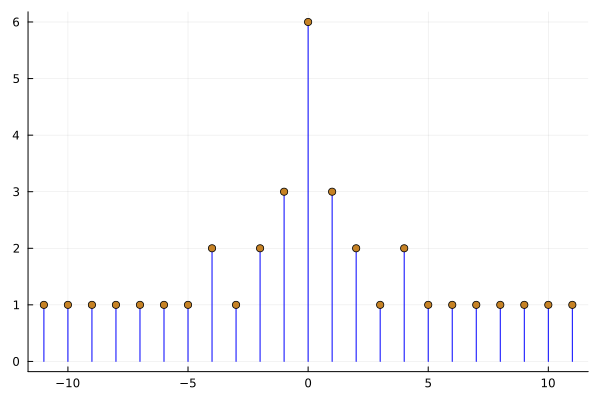

In [4]:
# Cardinality of the covariances observed in matrix R0
using Plots
max_dist = Int(((N^2-2)/2 +N-1)/2) # max correlation distance
xx       = -max_dist:max_dist      # correlation distance
p        = plot()
for x in xx
    p = plot!(p,[x,x],[0,sum(R0_dist.==x)],c=:blue,label="")
end
p = scatter!(xx,[sum(R0_dist.==x) for x in xx],label="")
p

In [5]:
# selection of unique distances in r0_dist
unique_dist = unique(r0_dist) 
# indices of the first occurences of unique distances
idx = unique(d -> r0_dist[d], 1:N^2);

In [6]:
perm = sortperm(unique_dist)
@assert unique_dist[perm] == -max_dist:max_dist

In [7]:
z1 = z[idx][perm]; # z restricted to unique distances and sorted by increasing correlation index

In [8]:
len = Int(N^2/4+N/2) # length of sub-arrays
Rs  = complex.(zeros(len,len),zeros(len,len))
for k=1:len
    u  = z1[k:k+len-1]
    Rs = Rs + u*u'
end
Rs = (1/sqrt(len))*Rs;

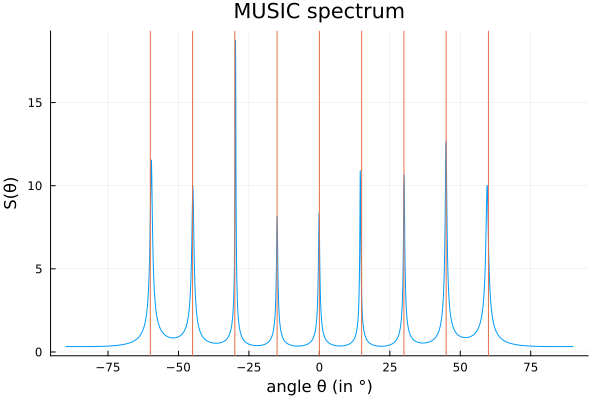

In [9]:
using LinearAlgebra: eigen,norm
λ, U = eigen(Rs)

U_noise = U[:,1:len-ns]

αα     = -90:.1:90
a(α)   = exp.(im*(1:len)*π*sind.(α))
Smusic = [1 ./norm(U_noise'*a(α)) for α in αα]

plot(αα,Smusic,label="",title="MUSIC spectrum")
vline!(θθ,label="")
xlabel!("angle θ (in °)")
ylabel!("S(θ)")